In [1]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Lesson: Deep Learning Regression Tutorial
#
# Description: Training Linear Regression with Keras 3 API
#    """
#    Project Description:
#    ------------------
#    This notebook demonstrates how to build a deep learning regression model using TensorFlow/Keras.
#    We'll generate synthetic data using scikit-learn, then build, train, and evaluate a neural network
#    for regression tasks. This tutorial is designed for educational purposes to help understand the
#    complete workflow of creating deep learning models for regression problems.
#
#    Objectives:
#    ----------
#    1. Learn how to generate synthetic regression data
#    2. Understand deep learning model architecture for regression
#    3. Learn the proper steps for data preprocessing
#    4. Build and compile a neural network using Keras
#    5. Train and evaluate the model's performance
#    6. Visualize the results and model predictions
#    """
# =======================================================================
#.          Copyright © Dr. Saad Laouadi 2024
# =======================================================================

In [1]:
# 1. Environment Setup
# ------------------
import os  
import sys 
from pathlib import Path
from pprint import pprint

# Disable Metal API Validation
os.environ["METAL_DEVICE_WRAPPER_TYPE"] = "0"

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

Author: Dr. Saad Laouadi

Last updated: 2024-11-29

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
pandas    : 2.2.2
numpy     : 1.26.4
matplotlib: 3.9.2
tensorflow: 2.16.2
sys       : 3.11.10 (main, Oct  3 2024, 02:26:51) [Clang 14.0.6 ]
sklearn   : 1.5.1
keras     : 3.6.0



In [5]:
# 2. Data Generation Function
# -------------------------
def generate_regression_data(n_samples=1000, n_features=1, noise=20.0, random_state=42):
    """
    Generate synthetic regression data using sklearn's make_regression.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_features : int
        Number of features (independent variables)
    noise : float
        Standard deviation of gaussian noise
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X : ndarray of shape (n_samples, n_features)
        Generated samples
    y : ndarray of shape (n_samples,)
        Target values
    """
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        random_state=random_state
    )
    
    # Reshape y to be a column vector
    y = y.reshape(-1, 1)
    
    return X, y

# Normalize the data
def normalize_data(df):
    """
    Normalize the features and target using StandardScaler.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing features and target
    
    Returns:
    --------
    X_scaled : numpy array
        Normalized features
    y_scaled : numpy array
        Normalized target
    scalers : tuple
        (X_scaler, y_scaler) for inverse transformation if needed
    """
    # Separate features and target
    X_data = df.drop('Y', axis=1)
    y_data = df['Y']
    
    # Create scalers
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    # Fit and transform the data
    X_scaled = X_scaler.fit_transform(X_data)
    y_scaled = y_scaler.fit_transform(y_data.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, (X_scaler, y_scaler)


def normalize_features_split(X_train, X_test):
    """
    Normalize features using StandardScaler after splitting.
    Fits on training data and transforms both training and test data.
    
    Parameters:
    -----------
    X_train : numpy array or DataFrame
        Training features
    X_test : numpy array or DataFrame
        Test features
    
    Returns:
    --------
    X_train_scaled : numpy array
        Normalized training features
    X_test_scaled : numpy array
        Normalized test features
    scaler : StandardScaler
        Fitted scaler for future transformations
    """
    # Create scaler
    scaler = StandardScaler()
    
    # Fit and transform training data
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Transform test data using training fit
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, scaler

# Regression Evaluation Metrics
def evaluate_regression_metrics(y_true, y_pred):
    """
    Calculate common regression metrics
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")

In [6]:
# Generate random data
X, y = generate_regression_data(n_samples=10000, n_features=3, random_state=101)
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (10000, 3)
Target shape: (10000, 1)


In [7]:
# Check the data description 
df = pd.DataFrame(data = np.concatenate([X, y], axis = 1),
                  columns = [f"X_{i}" for i in range(1,4)]+['Y']
                 )

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X_1,10000.0,-0.001262,0.994194,-3.806886,-0.674393,0.001271,0.676238,4.155123
X_2,10000.0,-0.004265,1.007255,-3.756504,-0.680627,-0.008693,0.678417,4.651961
X_3,10000.0,0.006563,0.996595,-3.919881,-0.665755,0.005914,0.666455,4.260621
Y,10000.0,0.453045,110.003277,-444.537202,-74.224674,-0.384304,74.285186,403.351975


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=101
)

print(f"The X train set shape: {X_train.shape}")
print(f"The X test set shape: {X_test.shape}")
print(f"The y train set shape: {y_train.shape}")
print(f"The y test set shape: {y_test.shape}")

The X train set shape: (8000, 3)
The X test set shape: (2000, 3)
The y train set shape: (8000, 1)
The y test set shape: (2000, 1)


In [10]:
# Scale the data

In [11]:
# Apply normalization to our split data
X_train_scaled, X_test_scaled, scaler = normalize_features_split(X_train, X_test)

# Verify the scaling
print("\nTraining set after scaling:")
print("X_train mean ≈ 0:", np.mean(X_train_scaled, axis=0))
print("X_train std ≈ 1:", np.std(X_train_scaled, axis=0))

print("\nTest set after scaling:")
print("X_test mean:", np.mean(X_test_scaled, axis=0))
print("X_test std:", np.std(X_test_scaled, axis=0))

print("\nTarget range (original scale):")
print("y_train min:", np.min(y_train))
print("y_train max:", np.max(y_train))
print("y_test min:", np.min(y_test))
print("y_test max:", np.max(y_test))


Training set after scaling:
X_train mean ≈ 0: [-4.34652314e-17  1.20771448e-17  5.88244731e-17]
X_train std ≈ 1: [1. 1. 1.]

Test set after scaling:
X_test mean: [-0.02600709 -0.00427045  0.0303087 ]
X_test std: [0.96583745 1.00918243 1.00488431]

Target range (original scale):
y_train min: -444.53720168135914
y_train max: 403.35197543963017
y_test min: -373.28898902886084
y_test max: 402.2616588583003


In [12]:
# Create the Neural Network Model
# ------------------------------

# """
# Step-by-step building of a neural network for regression using the Sequential Model.
# We will use EarlyStopping and ReduceOnPlateau Callbacks
# """


Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_layer_1 (Dense)           │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 11166.2227 - mae: 83.2407 - val_loss: 992.4158 - val_mae: 23.2954 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 659.7599 - mae: 20.0198 - val_loss: 476.5009 - val_mae: 17.4318 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 503.4693 - mae: 17.8114 - val_loss: 458.2144 - val_mae: 17.0688 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 473.2781 - mae: 17.3439 - val_loss: 441.5252 - val_mae: 16.8519 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 459.2949 - mae: 17.0358 - val_loss: 429.2897 - val_mae: 16.6038 - learning_rate: 0.0010
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 439.2473 - mae: 16.6859 - val_loss: 399.7976 - val_mae: 15.9637 - learning_rate: 0.0010
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 427.9219 - mae: 16.3513 - val_loss: 396.0024 - val

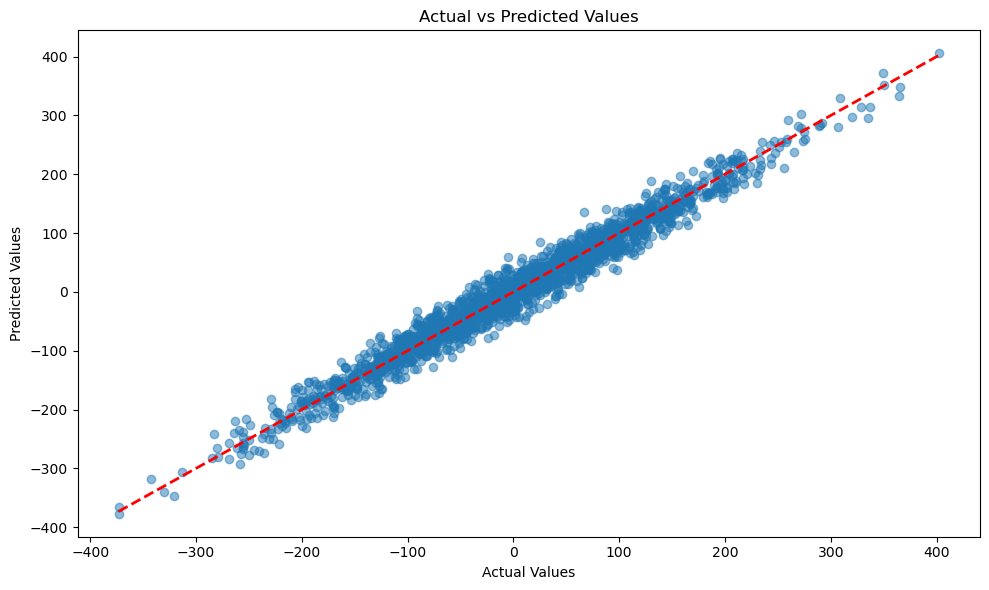

In [13]:
# 1. Create the input layer first
input_layer = Input(shape=(X_train.shape[1],), name='input_layer')

# 2. Create an empty sequential model
model = Sequential([
    # Start with the Input layer
    input_layer,
    
    # 3. First Dense Layer (previously called input layer)
    Dense(
        units=64,                     # Number of neurons in this layer
        activation='relu',            # Activation function
        name='dense_layer_1'          # Name to identify the layer
    ),
    
    # 4. First Hidden Layer
    Dense(
        units=32,                     # Number of neurons (smaller than previous layer)
        activation='relu',            # Same activation as before
        name='hidden_layer_1'         # Name for identification
    ),
    
    # 5. Second Hidden Layer
    Dense(
        units=16,                     # Even fewer neurons
        activation='relu',            # Same activation
        name='hidden_layer_2'         # Name for identification
    ),
    
    # 6. Output Layer
    Dense(
        units=1,                      # One neuron for regression
        activation=None,              # No activation for regression
        name='output_layer'           # Name for identification
    )
])

# 7. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with default learning rate
    loss='mean_squared_error',            # MSE loss for regression
    metrics=['mae']                       # Mean Absolute Error as additional metric
)

# 8. Print model summary to see the architecture
print("\nModel Architecture Summary:")
model.summary()

# 9. Adding Callbacks for Model Training Optimization
# ------------------------------------------------

# 9.1. Early Stopping to Prevent Overfitting:
# Early stopping helps prevent overfitting by monitoring the model's performance
# and stopping training when the model stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
                                 # Could also use 'val_mae' or other metrics
    
    patience=10,                # Number of epochs to wait for improvement
                                # If no improvement after 10 epochs, stop training
    
    restore_best_weights=True,  # After training, restore the model's weights
                                # to the epoch with best performance
    
    verbose=1                   # Print messages about early stopping
                                # 0: silent, 1: shows messages
)

# 9.2. Learning Rate Scheduling:
# Reduces the learning rate when the model's performance plateaus
# This helps fine-tune the model when it stops making large improvements
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',         # Monitor the validation loss
                               # Same metric as early stopping for consistency
    
    factor=0.2,                # Multiply learning rate by this factor when reducing
                               # New_lr = Current_lr * 0.2
    
    patience=5,                # Number of epochs to wait before reducing lr
                               # Shorter than early stopping patience
                               # Tries reducing lr before stopping completely
    
    min_lr=0.00001,           # Minimum learning rate allowed
                               # Prevents lr from becoming too small
    
    verbose=1                  # Print messages about lr reduction
                               # 0: silent, 1: shows messages
)

# Usage in model.fit():
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],  
    verbose=1
)

# 10. Train the model
print("\nTraining the model...")
history = model.fit(
    X_train_scaled,                             # Scaled input features
    y_train,                                    # Target values (not scaled)
    epochs=100,                                 # Number of training iterations
    batch_size=32,                              # Samples per training iteration
    validation_split=0.2,                       # Use 20% of training data for validation
    verbose=1,                                  # Show training progress
    callbacks= [early_stopping, reduce_lr]      # List of callbacks to use during training
)

# 11. Evaluate the model on test data
print("\nEvaluating the model on test data:")
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# 12. Make predictions
predictions = model.predict(X_test_scaled)

# 13. Visualize Results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()